-------------------------------------------------------------------
# Homework set 3 - solution

 * **Author**: Balint Szoke
 * **UniID**: bs2574

> This notebook grabs some price data from the Yahoo finance API for a list of companies stored in a separate csv file

-------------------------------------------------------------------


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import requests

In [2]:
#=======================================================================================
# Step 1: open and clean up the csv file
#
#         construct a list for the company codes and another one for the capitalizaiton
#=======================================================================================

csv_file = open('company_list_corrected.csv', 'r')
csv_file.readline()           # skip the header 

company_list, capital_list = [], []
companies_for_url = []

for line in csv_file:
    
    # -- NOTE ---------------------------------
    # There are company names with a comma, so I came up with a poor man's solution. 
    # Honestly, I'd rather use the csv module.   
    #------------------------------------------
    line = line.replace('"','')
    cols = line.strip().split(',')
    code, capital = cols[0], cols[-1]
    company_list.append(code)
    companies_for_url.append(code)
    companies_for_url.append('+')
    
    if capital[-1]=='M':
        capital_list.append(float(capital[:-1])/1000)
    elif capital[-1]=='B':
        capital_list.append(float(capital[:-1]))
    else:
        capital_list.append('NaN')
        

In [3]:
#===============================================================================================
# Step 2: take the company codes and download the price changes from yahoo
#
#         The yahoo API lets us download only 200 companies per call, so we need multiple rounds 
#         To make this easier, I use a little function (called construct_dp), which constructs 
#         the price changes for a given list of company codes (already separated by "+" signs).
#===============================================================================================


def construct_dp(list_symb):    
    '''
    This function takes a string including the company symbols (separated by + sign)
    download the associated price changes and return a list containing the price changes
    '''    
    #-----------------------------------------------
    # Download the prices for the given companies
    #-----------------------------------------------
    par = {'s': list_symb, 'f': 'sp2'}
    response = requests.get('http://finance.yahoo.com/d/quotes.csv', params = par)

    #-----------------------------------------------
    # Formatting the results
    #-----------------------------------------------
    downloaded_file = response.text.replace('"',"").splitlines()

    perc_change_list = []
    for line in downloaded_file:
        code, perc = line.split(',')
        try:
            perc = float(perc[1:-1])    # we need the abs value, simply cut off the sign
        except ValueError:
            perc = "NaN"
            
        perc_change_list.append(perc)
    
    return perc_change_list


#------------------------------------------------------------------
# Downloading the data 
#------------------------------------------------------------------

perc_change_list = []

onecall = 200
number_of_companies = len(company_list)
numb_rounds = int( number_of_companies/onecall ) +1

for ii in range(numb_rounds):
    lower_index = ii*onecall*2             # multiplied by 2 beacuse of the "+" signs
    upper_index = (ii + 1)*onecall*2       # multiplied by 2 beacuse of the "+" signs
    list_s = "".join( companies_for_url[lower_index:upper_index] )
    perc_change_list += construct_dp(list_s) 
    
print("Is the length of perc_change_list consistent with the number of companies?:")
print(len(perc_change_list) == len(company_list))

Is the length of perc_change_list consistent with the number of companies?:
True


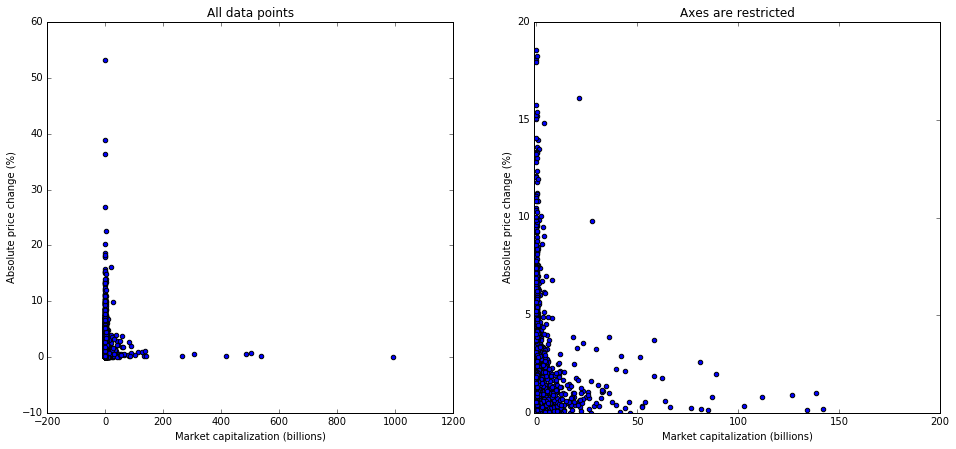

In [4]:
#===============================================================================================
# Step 3: Plotting
#         scatter plot of absolute value of percentage change against market capitalization
#         Right plot "drops" some "outliers" just to see how the "average" behaves
#===============================================================================================


fig, ax = plt.subplots(1,2, figsize=(16,7))

ax[0].scatter(capital_list,perc_change_list)
ax[0].set_ylabel("Absolute price change (%)")
ax[0].set_xlabel("Market capitalization (billions)")
ax[0].set_title("All data points")

ax[1].scatter(capital_list,perc_change_list)
ax[1].set_ylabel(r"Absolute price change (%)")
ax[1].set_xlabel("Market capitalization (billions)")
ax[1].set_xlim([-1,200])
ax[1].set_ylim([0,20])
ax[1].set_title("Axes are restricted")

#--------------------------------------------------------------------
# Are lower cap stocks more volatile according to this measure?
#   Yes, lower cap stocks seem to be more volatile
